# Shampoo Sale Forecasting Using LSTM and Keras

## 1. Data and basic analysis

In [1]:
# from pandas import read_csv
# from pandas import datetime
import matplotlib.pyplot as plt
import pandas as pd

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


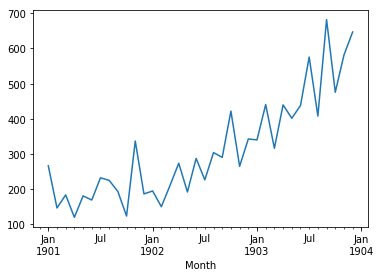

In [2]:
# load dataset
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')
series = pd.read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# summarize first few rows
print(series.head())

# line plot
series.plot()
plt.show()

In [3]:
# split data into train and test
X = series.values
print(X)

[266.  145.9 183.1 119.3 180.3 168.5 231.8 224.5 192.8 122.9 336.5 185.9
 194.3 149.5 210.1 273.3 191.4 287.  226.  303.6 289.9 421.6 264.5 342.3
 339.7 440.4 315.9 439.3 401.3 437.4 575.5 407.6 682.  475.3 581.3 646.9]


In [4]:
train, test = X[0:-12], X[-12:]

RMSE: 136.761


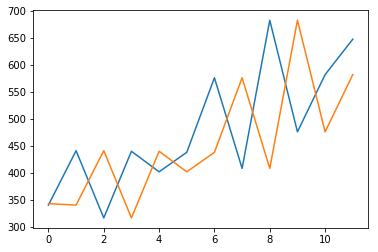

In [5]:
## The persistence forecast is where the observation from the prior time step (t-1) 
## is used to predict the observation at the current time step (t).

from sklearn.metrics import mean_squared_error
from math import sqrt
# walk-forward validation
history = [x for x in train]
predictions = []

for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    
    # observation
    history.append(test[i])

    # report performance

rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# line plot of observed vs predicted
plt.plot(test)
plt.plot(predictions)
plt.legend(loc=2)
plt.show()

In [6]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [8]:
# load dataset
series = pd.read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# transform to supervised learning
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


In [12]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# load dataset
series = pd.read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
print(len(series))

# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())

# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64
36
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


In [15]:
from sklearn.preprocessing import MinMaxScaler

series = pd.read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())

# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = pd.Series(scaled_X[:, 0])
print(scaled_series.head())

# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])
print(inverted_series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64
0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64
